In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("../data/PS_20174392719_1491204439457_log.csv")

In [4]:
df.shape

(6362620, 11)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


***

## EDA

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


0    6354407
1       8213
Name: isFraud, dtype: int64


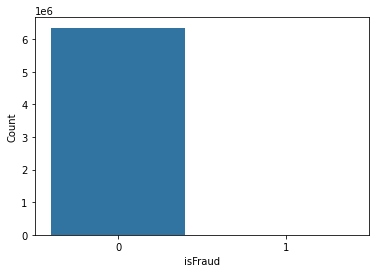

In [8]:
print(df.isFraud.value_counts())
sns.countplot(data=df, x='isFraud')
plt.ylabel('Count')
plt.rcParams["figure.figsize"] = (11,7)
plt.show()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64


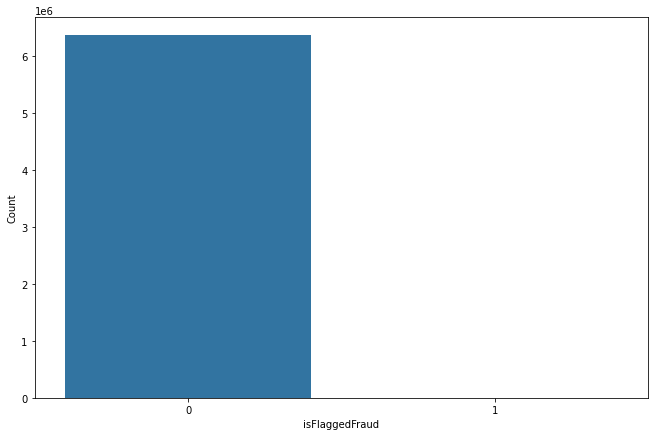

In [9]:
print(df.isFlaggedFraud.value_counts())
sns.countplot(data=df, x='isFlaggedFraud')
plt.ylabel('Count')
plt.rcParams["figure.figsize"] = (11,7)
plt.show()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


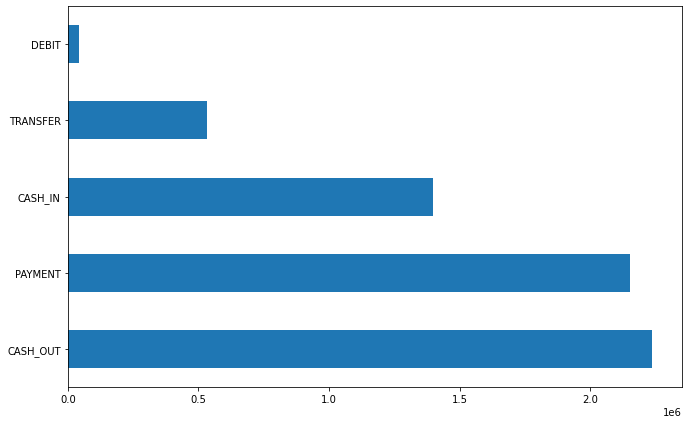

In [10]:
print(df.type.value_counts())
df.type.value_counts().plot(kind='barh')
plt.rcParams["figure.figsize"] = (11,7)
plt.show()

In [11]:
df.groupby('type')['isFraud','isFlaggedFraud'].sum()

C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


In [51]:
wrong_orig_bal = sum(df["oldbalanceOrg"] - df["amount"] != df["newbalanceOrig"])
wrong_dest_bal = sum(df["newbalanceDest"] + df["amount"] != df["newbalanceDest"])
print("Percentage of balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(df),2))
print("Percentage of balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(df),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


### Conclusion:

- We can conclude that the dataset is highly imbalanced.
- Frauds occurs in TRANSFERs and CASH_OUTs.
- Flagged fraud only occur in TRANSFER. 
- Although isFlaggedFraud exist, we will be dropping it due to its very low occurrence in the dataset.
- There are no empty and negative values however, there are some complications within the oldbalanceOrg and newbalanceDest

***

## Data Cleaning & Preprocessing

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,average_precision_score,confusion_matrix,classification_report, precision_recall_curve, plot_precision_recall_curve
from collections import Counter
from matplotlib import pyplot

In [13]:
df["errorBalanceOrg"] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
df["errorBalanceDest"] = df.oldbalanceDest + df.amount - df.newbalanceDest

In [14]:
droplist=['step','isFlaggedFraud','nameDest','nameOrig']
df.drop(labels=droplist,axis=1)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0.0,9.839640e+03
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0.0,1.864280e+03
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0.0,1.810000e+02
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0.0,2.136300e+04
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0.0,1.166814e+04
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0.0,0.000000e+00
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0.0,6.311409e+06
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0.0,1.000000e-02
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0.0,8.500025e+05


In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_toScale = df[['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest','errorBalanceOrg','errorBalanceDest']]
new_X = sc.fit(X_toScale)
X_scaled = new_X.transform(X_toScale)

In [16]:
scaled_df = pd.DataFrame(X_scaled, columns=['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest','errorBalanceOrg','errorBalanceDest'])

In [17]:
dummy_df = pd.DataFrame(pd.get_dummies(df['type']))
final_df = scaled_df.join(dummy_df, how = 'outer')

In [18]:
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))

In [19]:
def plot_curve(prediction):
    precision, recall, thresholds = precision_recall_curve(y_test,prediction)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--',label='Baseline')
    pyplot.plot(recall,precision, marker='.',label= 'Classifier')
    plt.rcParams["figure.figsize"] = (11,7)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend()

In [20]:
X = final_df
y = df.isFraud
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

***

## Modelling

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb

In [22]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()

### No sampling

In [23]:
lr_pipeline = make_pipeline(lr)
lr_model = lr_pipeline.fit(X_train, y_train)
lr_prediction = lr_model.predict(X_test)

In [24]:
model_result(lr_model,X_test, y_test)

AUPRC : 0.633769815981969
F1 - score : 0.5998383185125302
Confusion_matrix : 
[[1906188     163]
 [   1322    1113]]
accuracy_score
0.9992220186023997
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.87      0.46      0.60      2435

    accuracy                           1.00   1908786
   macro avg       0.94      0.73      0.80   1908786
weighted avg       1.00      1.00      1.00   1908786



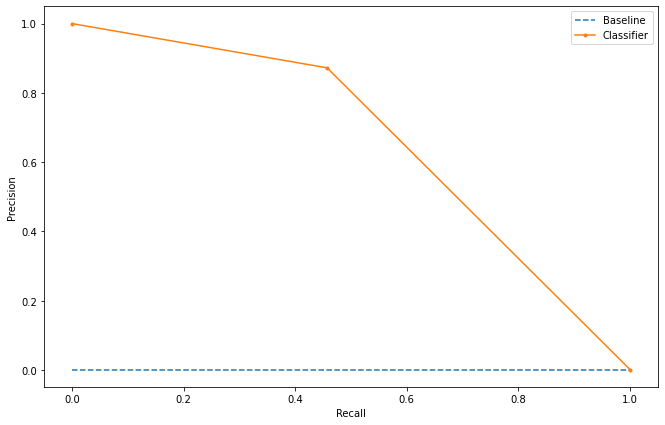

In [25]:
plot_curve(lr_prediction)

In [26]:
rf_pipeline = make_pipeline(rf)
rf_model = rf_pipeline.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)

In [27]:
model_result(rf_model,X_test, y_test)

AUPRC : 0.9958691979752143
F1 - score : 0.9973256531577865
Confusion_matrix : 
[[1906349       2]
 [     11    2424]]
accuracy_score
0.9999931893884385
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      1.00      1.00      2435

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



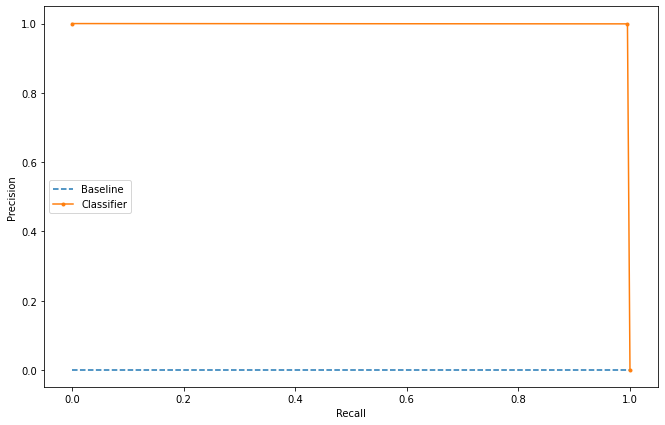

In [28]:
plot_curve(rf_prediction)

In [29]:
xgb_pipeline = make_pipeline(xgb)
xgb_model = xgb_pipeline.fit(X_train, y_train)
xgb_prediction = xgb_model.predict(X_test)

[07:59:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [30]:
model_result(xgb_model,X_test, y_test)

AUPRC : 0.9968301925110802
F1 - score : 0.9969167523124358
Confusion_matrix : 
[[1906346       5]
 [     10    2425]]
accuracy_score
0.9999921416020444
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      1.00      1.00      2435

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



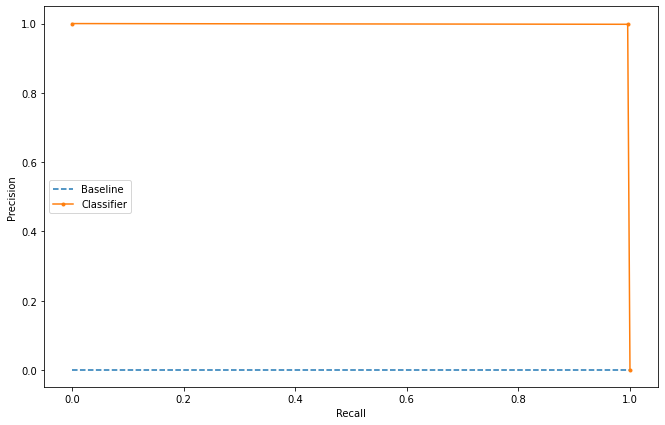

In [31]:
plot_curve(xgb_prediction)

### Random Undersampling

In [32]:
lr_rus_pipeline = make_pipeline_imb(RandomUnderSampler(), lr)
lr_rus_model = lr_rus_pipeline.fit(X_train, y_train)
lr_rus_prediction = lr_rus_model.predict(X_test)

In [33]:
model_result(lr_rus_model,X_test, y_test)

AUPRC : 0.5529496380559737
F1 - score : 0.04518014419625252
Confusion_matrix : 
[[1812127   94224]
 [    201    2234]]
accuracy_score
0.9505313848697549
classification_report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906351
           1       0.02      0.92      0.05      2435

    accuracy                           0.95   1908786
   macro avg       0.51      0.93      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



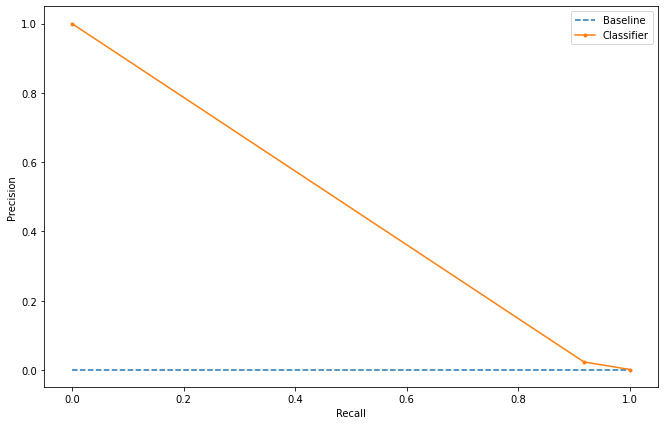

In [34]:
plot_curve(lr_rus_prediction)

In [35]:
rf_rus_pipeline = make_pipeline_imb(RandomUnderSampler(), rf)
rf_rus_model = rf_rus_pipeline.fit(X_train, y_train)
rf_rus_prediction = rf_rus_model.predict(X_test)

In [36]:
model_result(rf_rus_model,X_test, y_test)

AUPRC : 0.9906398154456377
F1 - score : 0.879304095686843
Confusion_matrix : 
[[1905694     657]
 [      9    2426]]
accuracy_score
0.9996510871307732
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.79      1.00      0.88      2435

    accuracy                           1.00   1908786
   macro avg       0.89      1.00      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



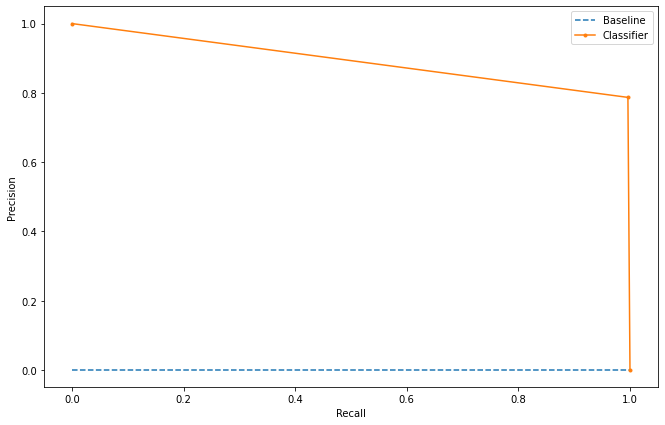

In [37]:
plot_curve(rf_rus_prediction)

In [38]:
xgb_rus_pipeline = make_pipeline_imb(RandomUnderSampler(), xgb)
xgb_rus_model = xgb_rus_pipeline.fit(X_train, y_train)
xgb_rus_prediction = xgb_rus_model.predict(X_test)

In [39]:
model_result(xgb_rus_model,X_test, y_test)

AUPRC : 0.989079879516456
F1 - score : 0.6671246050281632
Confusion_matrix : 
[[1903935    2416]
 [      7    2428]]
accuracy_score
0.9987306067835787
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.50      1.00      0.67      2435

    accuracy                           1.00   1908786
   macro avg       0.75      1.00      0.83   1908786
weighted avg       1.00      1.00      1.00   1908786



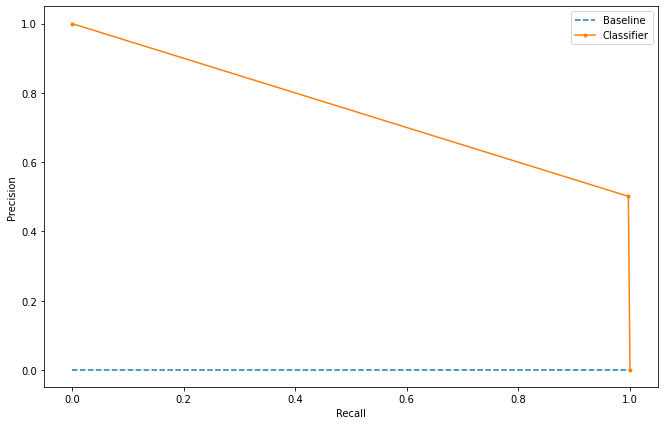

In [40]:
plot_curve(xgb_rus_prediction)

### SMOTE

In [41]:
lr_smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), lr)
lr_smote_model = lr_smote_pipeline.fit(X_train, y_train)
lr_smote_prediction = lr_smote_model.predict(X_test)

C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
model_result(lr_smote_model,X_test, y_test)

AUPRC : 0.5463760323577583
F1 - score : 0.043995415539011255
Confusion_matrix : 
[[1807241   99110]
 [    151    2284]]
accuracy_score
0.9479978373688827
classification_report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906351
           1       0.02      0.94      0.04      2435

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



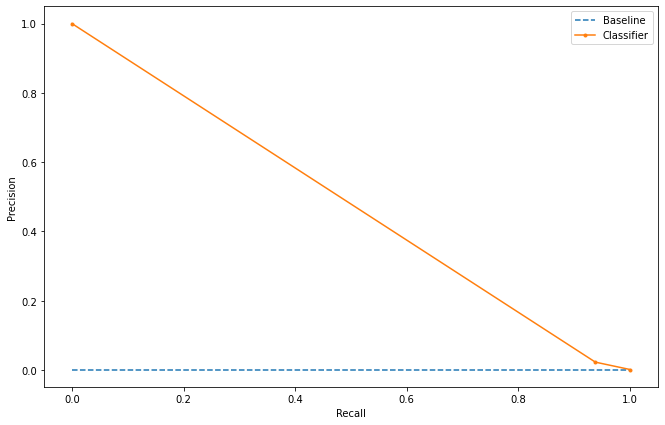

In [43]:
plot_curve(lr_smote_prediction)

In [44]:
rf_smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), rf)
rf_smote_model = rf_smote_pipeline.fit(X_train, y_train)
rf_smote_prediction = rf_smote_model.predict(X_test)

In [45]:
model_result(rf_smote_model,X_test, y_test)

AUPRC : 0.9846554402072628
F1 - score : 0.940469265076595
Confusion_matrix : 
[[1906054     297]
 [     10    2425]]
accuracy_score
0.9998391647885095
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.89      1.00      0.94      2435

    accuracy                           1.00   1908786
   macro avg       0.95      1.00      0.97   1908786
weighted avg       1.00      1.00      1.00   1908786



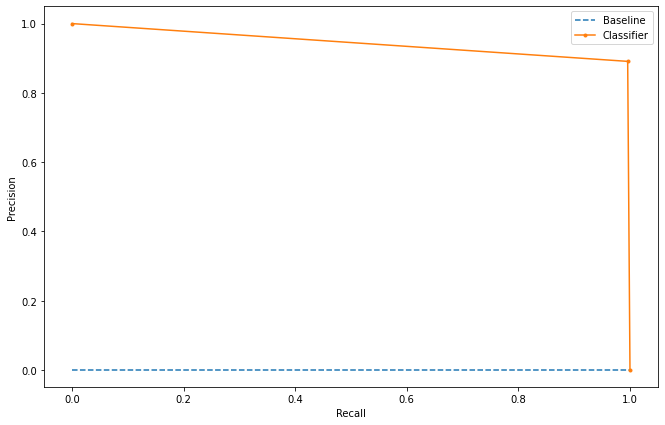

In [46]:
plot_curve(rf_smote_prediction)

In [47]:
xgb_smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), xgb)
xgb_smote_model = xgb_smote_pipeline.fit(X_train, y_train)
xgb_smote_prediction = xgb_smote_model.predict(X_test)

In [48]:
model_result(xgb_smote_model,X_test, y_test)

AUPRC : 0.9961591991573076
F1 - score : 0.9234577303884236
Confusion_matrix : 
[[1905959     392]
 [     10    2425]]
accuracy_score
0.999789394934791
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.86      1.00      0.92      2435

    accuracy                           1.00   1908786
   macro avg       0.93      1.00      0.96   1908786
weighted avg       1.00      1.00      1.00   1908786



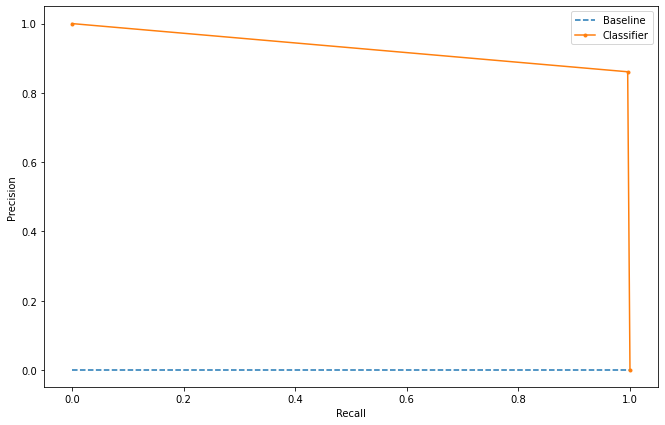

In [49]:
plot_curve(xgb_smote_prediction)

In [50]:
print("Normal class distribution: {}".format(Counter(df['isFraud'])))
X_rus, y_rus = RandomUnderSampler().fit_sample(X,y)
print("Random Under Sample class distribution: {}".format(Counter(y_rus)))
X_smote, y_smote = SMOTE().fit_sample(X,y)
print("SMOTE class distribution: {}".format(Counter(y_smote)))

Normal class distribution: Counter({0: 6354407, 1: 8213})
Random Under Sample class distribution: Counter({0: 8213, 1: 8213})
SMOTE class distribution: Counter({0: 6354407, 1: 6354407})


## Cross validation

In [52]:
%%time
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])
scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])
scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])

C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Cross validation confisuion matrix wiht cv = 5
[0.9992197735210218, 0.9992377355694587, 0.9992208961490491, 0.9992399808255132, 0.9992332441965679]
Cross validation confisuion matrix wiht cv = 5
[0.9999932642318362, 0.9999943868598634, 0.9999921416038089, 0.999996632115918, 0.9999955094828495]
Cross validation confisuion matrix wiht cv = 5
[0.9999910189757816, 0.9999943868598634, 0.9999910189757816, 0.9999943868598634, 0.999994386853562]
Wall time: 1h 26min


In [55]:
%%time
scores = cross_val_score(lr_rus_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])
scores = cross_val_score(rf_rus_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])
scores = cross_val_score(xgb_rus_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])

C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Cross validation confisuion matrix wiht cv = 5
[0.9491988365083125, 0.9482850172940848, 0.9483029793425217, 0.9495917563178699, 0.9483085344523702]
Cross validation confisuion matrix wiht cv = 5
[0.9996261648669068, 0.9997687386263748, 0.9997900685588936, 0.9998192568876036, 0.9997765967717672]
Cross validation confisuion matrix wiht cv = 5
[0.9985675266371565, 0.9984822069070812, 0.9991322085348918, 0.9985293572842281, 0.9990390293298128]
Wall time: 2min 1s


In [56]:
%%time
scores = cross_val_score(lr_smote_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])
scores = cross_val_score(rf_smote_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])
scores = cross_val_score(xgb_smote_pipeline, X_train, y_train, cv=5)
print('Cross validation confisuion matrix wiht cv = 5')
print([s for s in scores])

C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\aizad\anaconda3\envs\fds\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Cross validation confisuion matrix wiht cv = 5
[0.9489136889893766, 0.947612563105728, 0.9519616240835146, 0.9488294918873286, 0.9489372068534273]
Cross validation confisuion matrix wiht cv = 5
[0.9998529357284228, 0.9998607941246139, 0.9998742656609416, 0.999799049583112, 0.9998125209089704]
Cross validation confisuion matrix wiht cv = 5
[0.9997631254862382, 0.9998069079793033, 0.9998192568876036, 0.9997575123461018, 0.9997889456939308]
Wall time: 3h 19min 5s
